# Stacked Autoencoders for Classification of Quantum Measurements
Thanks to Théau Peronnin for providing the original code and the original data [arXiv:1904.04635].

In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import sys
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
hdf = h5py.File(r"datasets/example_data_very_short.h5", "r")
data = np.array(hdf["data_tensor"])
print(data.shape)
[np.mean(data), np.var(data), np.std(data)]

(200000, 2, 100)


[-0.0028620095, 0.0026083235, 0.05107175]

In [2]:
d_transform = data
d_transform.shape

(200000, 2, 100)

## Visualisation of the Traces V(t)

0 99
0.0 1.0


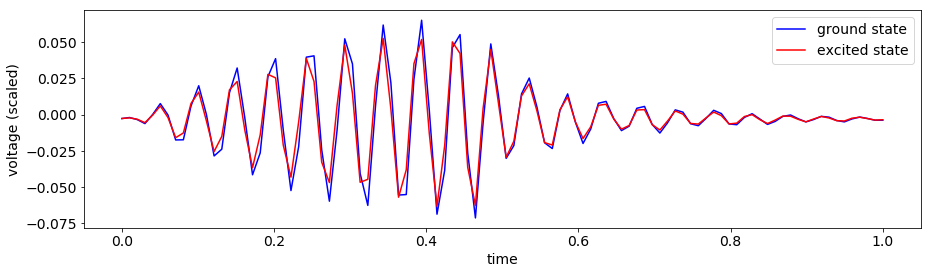

(2, 100)

In [3]:
d_av = np.mean(d_transform, axis=0)
t = np.array(range(len(d_transform[0, 0])))
print(t[0], t[-1])
xf = np.arange(len(t))*1./t[-1]
print(xf[0], xf[-1])
# plot average signals
plt.figure(figsize=(15,4))
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.xlabel("time", fontsize=14)
plt.ylabel("voltage (scaled)", fontsize=14)
plt.plot(xf, d_av[0], "b-", label="ground state")
plt.plot(xf, d_av[1], "r-", label="excited state")
plt.legend(loc="best", fontsize=14)
plt.show()
d_av.shape

## Demodulation (for a given set of parameters)


In [4]:
d = d_transform
#Construction of the demodulation weight function w(t) = x + iy 
x = (d_av[1]-d_av[0])/2.
y = np.real(np.fft.irfft(np.fft.rfft(x, axis = -1)*1j,x.shape[0], axis = -1)) 
#Normalazing : actual axis not calibrated for this experiment
x = x/np.sqrt(np.sum(x**2))
y = y/np.sqrt(np.sum(y**2))
#Demodulation
dIQ = d*(x+1j*y)
dint = np.average(dIQ,axis = -1)
dint = dint.T
dint.shape

(2, 200000)

In [5]:
# Histogram functions
a = np.amax(np.abs(dint)) #fixing the range
r = [[-a,a],[-a,a]]
def hist(dint,ge):
    h = np.histogram2d(np.real(dint[ge]),np.imag(dint[ge]), bins = 50, normed = False, range = r)[0]
    return h    
def ol(dint): # 2d scalar product
    Pg = hist(dint,0)
    Pe = hist(dint,1)
    o = np.sum(Pg*Pe)/(np.sqrt(np.sum(Pg**2))*np.sqrt(np.sum(Pe**2)))
    return o
print("Overlap : "+str(ol(dint)*100) +"%")
def Z(data,ge): #Defining the zone associated with either g or e
    z = hist(data,ge) >  hist(data,1-ge)
    z = z + (hist(data,ge) ==  hist(data,1-ge))*0.5
    return z
def ol_z(data,ge): #Computation of the error
    o = np.sum(Z(data,ge)*hist(data,ge))/np.sum(hist(data,ge))
    return o
print("Error by zone, g: "+str((1-ol_z(dint,0))*100) +"%, e: "+str((1-ol_z(dint,1))*100) +"%")
fidelity = ((ol_z(dint,0)) + (ol_z(dint,1)))/2 * 100
print("Fidelity: " + str(fidelity) + "%" )

Overlap : 90.6024849955735%
Error by zone, g: 16.509249999999998%, e: 53.92675%
Fidelity: 64.78200000000001%


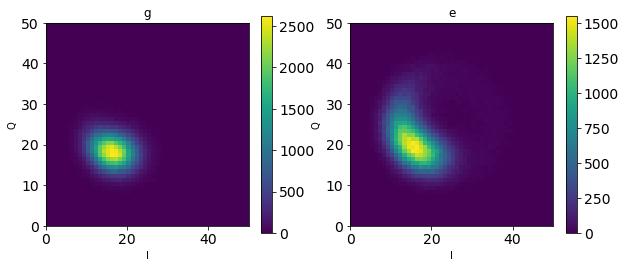

In [6]:
# make plot with 2 subplots
fig, ax = plt.subplots(1,2, figsize=(10, 4))
# subplot 1
plot = ax[0].pcolormesh(hist(dint,0)) # histogram for ground state
fig.colorbar(plot,ax=ax[0],orientation="vertical")
ax[0].set_xlabel("I") # Re[\beta], see Eq. (2)
ax[0].set_ylabel("Q") # Im[\beta], see Eq. (2)
ax[0].set_title("g")  # ground state label
ax[0].axis("tight")   # save space
ax[0].set_aspect(1)   # aspect ratio
# subplot 2
plot = ax[1].pcolormesh(hist(dint,1)) # histogram for excited state; as above
fig.colorbar(plot,ax=ax[1],orientation="vertical")
ax[1].set_xlabel("I") # Re[\beta], see Eq. (2)
ax[1].set_ylabel("Q") # Im[\beta], see Eq. (2)
ax[1].set_title("e")  # excited state label
ax[1].axis("tight")   # save space
ax[1].set_aspect(1)
# show all subplots
plt.show()

## Dataset Preparation

In [7]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
print(d_g.shape)
d_g[0:3, 0:2]

(200000, 101)


array([[ 0.        , -0.00947497],
       [ 0.        ,  0.07355312],
       [ 0.        , -0.01357753]])

In [8]:
d_g = d_transform[:, 0, :]                           # ground state features
class_g = np.array([[0 for i in range(len(d_g))]]).T # ground state labels
d_g = np.concatenate((class_g, d_g), axis=1)         # ground state features, labels
d_e = d_transform[:, 1, :]                           # excited state features
class_e = np.array([[1 for i in range(len(d_e))]]).T # excited state labels
d_e = np.concatenate((class_e, d_e), axis=1)         # excited state features, labels
ge_data = np.concatenate((d_g, d_e), axis=0)         # ground and excited state labels, features
print(ge_data.shape)                                 # instances, label + features
# for np.random.seed, see https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do/21494630
np.random.seed(0)
shuffle_index = np.random.permutation(len(ge_data))  # create a random order (via indices)
print(shuffle_index[:5])                             # show a few randomized indices
first_5_pseudo_random = np.array([242160, 3413, 393024, 247987, 52436])
print(np.linalg.norm(first_5_pseudo_random - shuffle_index[:5]) == 0)
ge_shuffle_data = ge_data[shuffle_index]             # apply the random order
X_data = ge_shuffle_data[:, 1:]                      # select the features ...
Y_data = ge_shuffle_data[:, :1]                      # ... and the labels
print(X_data.shape)    # shape of feature data
print(Y_data.shape)    # shape of label data
print(X_data[:10, :5]) # for the first 10 instances, show the first 5 features, ...
Y_data[:10]            # ... and the according label

(400000, 101)
[242160   3413 393024 247987  52436]
True
(400000, 100)
(400000, 1)
[[ 0.04385836  0.07316239  0.01162393 -0.03096459 -0.0034188 ]
 [ 0.02803419 -0.05655678 -0.09797314 -0.01494506  0.06398047]
 [ 0.02119658  0.02393162  0.04424908 -0.0157265  -0.07238095]
 [-0.05870574  0.05714286  0.00986569  0.00673993  0.03350427]
 [-0.04229548 -0.04678877  0.01924298 -0.02295482 -0.04678877]
 [-0.02881563 -0.05245421  0.03096459  0.0790232   0.00908425]
 [-0.04327228 -0.00830281  0.00771673 -0.01494506  0.02764347]
 [-0.00283272 -0.01221001  0.01103785  0.03838828  0.0206105 ]
 [-0.0254945  -0.01885226  0.01025641  0.04815629 -0.03428571]
 [-0.04444445 -0.00576313  0.05323565  0.00634921 -0.01943834]]


array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [9]:
print(len(Y_data))
split1 = int(0.8 * len(Y_data))
split2 = int(0.8 * split1)
# use test data for evaluation of the final (!) model (after development)
X_test, Y_test = X_data[split1:], Y_data[split1:]
print(X_test.shape, Y_test.shape)
# use validation data for early stopping and evaluation of different models (during development)
X_valid, Y_valid = X_data[split2:split1], Y_data[split2:split1]
print(X_valid.shape, Y_valid.shape)
# use training data for training / fitting different models (during development)
X_train, Y_train = X_data[:split2], Y_data[:split2]
print(X_train.shape, Y_train.shape)
# scaling all data by training set
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
print(X_train_mean, X_train_std)
X_train = (X_train - X_train_mean) / X_train_std
X_valid = (X_valid - X_train_mean) / X_train_std
X_test  = (X_test  - X_train_mean) / X_train_std

400000
(80000, 100) (80000, 1)
(64000, 100) (64000, 1)
(256000, 100) (256000, 1)
-0.0028560917035001143 0.05106889604001522


In [10]:
# separate training and validatoin datasets into ground- and excited state datasets
# training
g_X_train = []
e_X_train = []
for i in range(int(len(X_train))):
    if int(Y_train[i])==0:
        g_X_train.append(X_train[i])
    else:
        e_X_train.append(X_train[i])
g_X_train = np.array(g_X_train)
print(g_X_train.shape)
e_X_train = np.array(e_X_train)
print(e_X_train.shape)
# validation
g_X_valid = []
e_X_valid = []
for i in range(int(len(X_valid))):
    if int(Y_valid[i])==0:
        g_X_valid.append(X_valid[i])
    else:
        e_X_valid.append(X_valid[i])
g_X_valid = np.array(g_X_valid)
print(g_X_valid.shape)
e_X_valid = np.array(e_X_valid)
print(e_X_valid.shape)

(128340, 100)
(127660, 100)
(31842, 100)
(32158, 100)


100.00000000000007 (100,)
99.99999999999994 (100,)


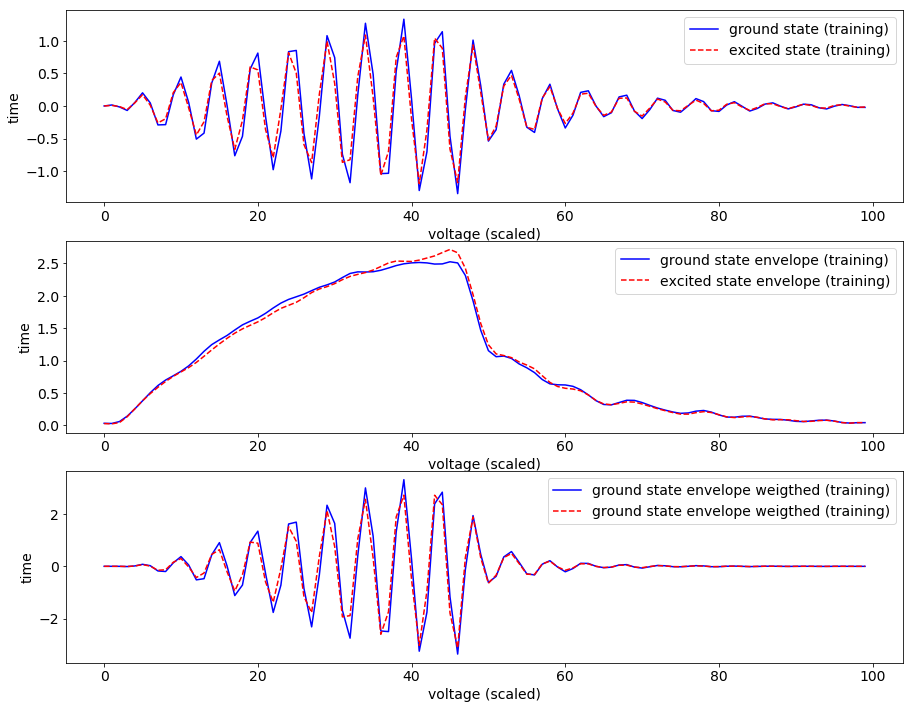

In [11]:
# average signals
g_avg = np.mean(g_X_train, axis=0)
e_avg = np.mean(e_X_train, axis=0)
# average envelope amplitude
g_env = np.abs(hilbert(g_avg))
g_env = g_env * len(g_env) / sum(g_env)
print(sum(g_env), g_env.shape)
e_env = np.abs(hilbert(e_avg))
e_env = e_env * len(e_env) / sum(e_env)
print(sum(e_env), e_env.shape)
# envelope weighted average
g_wen = g_avg * g_env
e_wen = e_avg * e_env
# x-axis and figure
xf = range(100)
fig, ax = plt.subplots(3,1, figsize=(15,12))
# subplot 1
ax[0].plot(xf, g_avg, "b-", label="ground state (training)")
ax[0].plot(xf, e_avg, "r--", label="excited state (training)")
ax[0].set_xlabel("voltage (scaled)", fontsize=14)
ax[0].set_ylabel("time", fontsize=14)
ax[0].axis("tight")
ax[0].legend(loc="best", fontsize=14)
# subplot 2
ax[1].plot(xf, g_env, "b-", label="ground state envelope (training)")
ax[1].plot(xf, e_env, "r--", label="excited state envelope (training)")
ax[1].set_xlabel("voltage (scaled)", fontsize=14)
ax[1].set_ylabel("time", fontsize=14)
ax[1].axis("tight")
ax[1].legend(loc="best", fontsize=14)
# subplot 3
ax[2].plot(xf, g_wen, "b-", label="ground state envelope weigthed (training)")
ax[2].plot(xf, e_wen, "r--", label="ground state envelope weigthed (training)")
ax[2].set_xlabel("voltage (scaled)", fontsize=14)
ax[2].set_ylabel("time", fontsize=14)
ax[2].axis("tight")
ax[2].legend(loc="best", fontsize=14)
plt.show()

## Classification via Two Stacked Autoencoders with One Matryoshka Level
One stacked autoencoder is trained on the ground states and another one on the excited states. When a new, unknown instance is fed, the autoencoder with the lower reconstruction error should identify the eigenstate. Instead of just taking the lower number, a network with one hidden layer is trained to classify the instance.
Data will be saved in folders under `./Autoencoder_logs`.

In [12]:
# verify that multiplying the datasets with an envelope yields the desired result
n = 4                           # any instance
print(g_X_train.shape)          # shape of dataset
print(g_X_train[n,:5])          # show first 5 features of instance n
print((g_X_train*g_env)[n,:5])  # multiply dataset by envelope and then show first 5 features of instance n
print((g_X_train[n]*g_env)[:5]) # multiply instance n by envelope and then show first 5 features: result is the same

(128340, 100)
[-0.8143578  -0.05692377  1.09835438  0.18025254 -0.32470347]
[-0.02751719 -0.00178678  0.06701977  0.02587942 -0.08335001]
[-0.02751719 -0.00178678  0.06701977  0.02587942 -0.08335001]


In [13]:
### construction
# architecture
reset_graph()
n_inputs = 100
n_hidden1 = 20
n_hidden2 = 4  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs
# training details
learning_rate = 0.01
l2_reg = 0.01
n_epochs = [3000, 3000]        # [100, 100]
batch_sizes = [150, 150]
early_stopping_threshold = 200 # 16
# layer details (activation, regularization, initialization)
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])
# trainable variables
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")
# layers
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)                              # optimizer
### execution
with tf.name_scope("phase1"):                                                  # phase 1
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4                    # skip layers 2 and 3: use hidden1
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X)) # reconstruction loss
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)            # regularization loss (no tying!)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss                 # total loss in phase 1
    phase1_training_op = optimizer.minimize(phase1_loss)                       # training op in phase 1
with tf.name_scope("phase2"):                                                  # phase 2
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))  # focus on the middle part: 1, 2, and 3
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)            # regularization loss of layers 2 and 3
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss                 # total loss in phase 2
    train_vars = [weights2, biases2, weights3, biases3]                        # train only these variables
    phase2_training_op = optimizer.minimize(phase2_loss, var_list =train_vars) # training operation in phase 2
### initializer, training operations, and cost function
init = tf.global_variables_initializer()                                       # initializer node
training_ops = [phase1_training_op, phase2_training_op]                        # list of training operations
reconstruct_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]  # list of reconstruction losses
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))                   # final (overall) reconstruction loss
# ground states
saver_g = tf.train.Saver()
print("ground states autoencoder")
with tf.Session() as sess:                                                     # start session
    init.run()                                                                 # initialize all variables
    for phase in range(2):                                                     # loop over 0 + 1 Matryoshka levels
        learning_rate = 0.01
        loss_val_min = np.inf
        count = 0
        print("Training phase #{}".format(phase + 1))                          # print current phase
        for epoch in range(n_epochs[phase]):                                   # loop over epochs
            n_batches = len(g_X_train) // batch_sizes[phase]                   # number of batches
            for iteration in range(n_batches+1):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch = g_X_train[int(iteration*batch_sizes[phase]):int((iteration+1)*batch_sizes[phase])]
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_val = reconstruct_losses[phase].eval(feed_dict={X:g_X_valid}) # get current reconstruction loss ...
            print("\r{}".format(epoch), "Validation MSE:", loss_val)           # ... and print it
            if loss_val < loss_val_min:
                loss_val_min = loss_val
                count = 0
                saver_g.save(sess, "./Autoencoder_logs/g_encoder/g_encoder")
            else:
                count += 1
                if count == round(early_stopping_threshold/2):
                    learning_rate /= 2
                    print("learning_rate: {}".format(learning_rate))
                    print("min validation loss: {}".format(loss_val_min))
                if count > early_stopping_threshold:
                    print("Early stopping!")
                    break
        saver_g.restore(sess, "./Autoencoder_logs/g_encoder/g_encoder")
        print("Computing final reconstruction loss on the validation set.")
        loss_val = reconstruct_losses[phase].eval(feed_dict={X: g_X_valid})
        print("Final validation reconstruction loss:", loss_val)
    g_X_train_reconstruction = outputs.eval(feed_dict={X: X_train})
    g_X_valid_reconstruction = outputs.eval(feed_dict={X: X_valid})
    g_X_test_reconstruction = outputs.eval(feed_dict={X: X_test})
# excited states
saver_e = tf.train.Saver()
print("\nexcited states autoencoder")
with tf.Session() as sess:                                                     # start session
    init.run()                                                                 # initialize all variables
    for phase in range(2):                                                     # loop over phases
        learning_rate = 0.01
        loss_val_min = np.inf
        count = 0
        print("Training phase #{}".format(phase + 1))                          # print current phase
        for epoch in range(n_epochs[phase]):                                   # loop over epochs
            n_batches = len(e_X_train) // batch_sizes[phase]                   # number of batches
            for iteration in range(n_batches+1):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch = e_X_train[int(iteration*batch_sizes[phase]):int((iteration+1)*batch_sizes[phase])]
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_val = reconstruct_losses[phase].eval(feed_dict={X:e_X_valid}) # get current reconstruction loss ...
            print("\r{}".format(epoch), "Validation MSE:", loss_val)           # ... and print it
            if loss_val < loss_val_min:
                loss_val_min = loss_val
                count = 0
                saver_e.save(sess, "./Autoencoder_logs/e_encoder/e_encoder")
            else:
                count += 1
                if count == round(early_stopping_threshold/2):
                    learning_rate /= 2
                    print("learning_rate: {}".format(learning_rate))
                    print("min validation loss: {}".format(loss_val_min))
                if count > early_stopping_threshold:
                    print("Early stopping!")
                    break
        saver_e.restore(sess, "./Autoencoder_logs/e_encoder/e_encoder")
        print("Computing final reconstruction loss on the validation set.")
        loss_val = reconstruct_losses[phase].eval(feed_dict={X: e_X_valid})
        print("Final validation reconstruction loss:", loss_val)
    e_X_train_reconstruction = outputs.eval(feed_dict={X: X_train})
    e_X_valid_reconstruction = outputs.eval(feed_dict={X: X_valid})
    e_X_test_reconstruction = outputs.eval(feed_dict={X: X_test})
###
# output
print("\noutput")
print(g_X_train_reconstruction.shape, g_X_valid_reconstruction.shape, g_X_test_reconstruction.shape)
print(e_X_train_reconstruction.shape, e_X_valid_reconstruction.shape, e_X_test_reconstruction.shape)
# reconstruction errors, predictions, and fidelities
g_train_errors = np.mean(np.square((g_X_train_reconstruction-X_train)), axis=1)
e_train_errors = np.mean(np.square((e_X_train_reconstruction-X_train)), axis=1)
train_preds = np.heaviside(g_train_errors - e_train_errors, 0)   # g_error > e_error => probably excited state
train_errors = np.abs(train_preds - Y_train[:, 0])
train_fidelity = 1 - (sum(train_errors)/len(train_errors))
print("\ntraining fidelity: \t"+ str(100*train_fidelity) + " %") # fidelity in %
g_valid_errors = np.mean(np.square((g_X_valid_reconstruction-X_valid)), axis=1)
e_valid_errors = np.mean(np.square((e_X_valid_reconstruction-X_valid)), axis=1)
valid_preds = np.heaviside(g_valid_errors - e_valid_errors, 0)   # g_error > e_error => probably excited state
valid_errors = np.abs(valid_preds - Y_valid[:, 0])
valid_fidelity = 1 - (sum(valid_errors)/len(valid_errors))
print("validation fidelity: \t"+ str(100*valid_fidelity) + " %") # fidelity in %
g_test_errors = np.mean(np.square((g_X_test_reconstruction-X_test)), axis=1)
e_test_errors = np.mean(np.square((e_X_test_reconstruction-X_test)), axis=1)
test_preds = np.heaviside(g_test_errors - e_test_errors, 0)      # g_error > e_error => probably excited state
test_errors = np.abs(test_preds - Y_test[:, 0])
test_fidelity = 1 - (sum(test_errors)/len(test_errors))
print("testing fidelity: \t"+ str(100*test_fidelity) + " %")     # fidelity in %

ground states autoencoder
Training phase #1
0 Validation MSE: 0.40448394
1 Validation MSE: 0.4032861
2 Validation MSE: 0.40242282
3 Validation MSE: 0.4019402
4 Validation MSE: 0.40168002
5 Validation MSE: 0.4015272
6 Validation MSE: 0.40145722
7 Validation MSE: 0.40141362
8 Validation MSE: 0.4013915
9 Validation MSE: 0.40137908
10 Validation MSE: 0.40136942
11 Validation MSE: 0.40136293
12 Validation MSE: 0.40135956
13 Validation MSE: 0.4013637
14 Validation MSE: 0.40137663
15 Validation MSE: 0.40139875
16 Validation MSE: 0.4014217
17 Validation MSE: 0.40144482
18 Validation MSE: 0.40146372
19 Validation MSE: 0.40147686
20 Validation MSE: 0.40148345
21 Validation MSE: 0.40148845
22 Validation MSE: 0.40149277
23 Validation MSE: 0.40149134
24 Validation MSE: 0.4014861
25 Validation MSE: 0.4014771
26 Validation MSE: 0.40146053
27 Validation MSE: 0.40144458
28 Validation MSE: 0.4014232
29 Validation MSE: 0.401402
30 Validation MSE: 0.40138158
31 Validation MSE: 0.40136132
32 Validation MSE

267 Validation MSE: 0.40124497
268 Validation MSE: 0.4012257
269 Validation MSE: 0.4012083
270 Validation MSE: 0.40119386
271 Validation MSE: 0.40118378
272 Validation MSE: 0.40117612
273 Validation MSE: 0.40117663
274 Validation MSE: 0.4011834
275 Validation MSE: 0.40119338
276 Validation MSE: 0.40119866
277 Validation MSE: 0.40120795
278 Validation MSE: 0.4012198
279 Validation MSE: 0.40123445
280 Validation MSE: 0.4012452
281 Validation MSE: 0.40125042
282 Validation MSE: 0.40125275
283 Validation MSE: 0.4012525
284 Validation MSE: 0.40124997
285 Validation MSE: 0.40124965
286 Validation MSE: 0.4012474
287 Validation MSE: 0.4012438
288 Validation MSE: 0.40123838
289 Validation MSE: 0.40122542
290 Validation MSE: 0.40121335
291 Validation MSE: 0.40120092
292 Validation MSE: 0.40118596
293 Validation MSE: 0.40117356
294 Validation MSE: 0.4011619
295 Validation MSE: 0.40114784
296 Validation MSE: 0.40114212
297 Validation MSE: 0.4011375
298 Validation MSE: 0.40113407
299 Validation MSE

533 Validation MSE: 0.40132925
534 Validation MSE: 0.4013302
535 Validation MSE: 0.4013287
536 Validation MSE: 0.401323
537 Validation MSE: 0.40131992
538 Validation MSE: 0.40132982
539 Validation MSE: 0.4013435
540 Validation MSE: 0.40135705
541 Validation MSE: 0.40136376
542 Validation MSE: 0.4013646
543 Validation MSE: 0.4013566
544 Validation MSE: 0.40134752
545 Validation MSE: 0.40134045
546 Validation MSE: 0.40133598
547 Validation MSE: 0.40133172
548 Validation MSE: 0.40132943
549 Validation MSE: 0.4013333
550 Validation MSE: 0.40133604
551 Validation MSE: 0.40133792
552 Validation MSE: 0.40133637
553 Validation MSE: 0.4013301
554 Validation MSE: 0.40131998
555 Validation MSE: 0.40131113
556 Validation MSE: 0.4013014
557 Validation MSE: 0.40128702
558 Validation MSE: 0.40127653
559 Validation MSE: 0.40127778
560 Validation MSE: 0.40127784
561 Validation MSE: 0.40127438
562 Validation MSE: 0.40126687
563 Validation MSE: 0.4012594
564 Validation MSE: 0.4012499
565 Validation MSE: 

797 Validation MSE: 0.40130123
798 Validation MSE: 0.40129775
799 Validation MSE: 0.40128818
800 Validation MSE: 0.40128258
801 Validation MSE: 0.40127277
802 Validation MSE: 0.40125832
Early stopping!
INFO:tensorflow:Restoring parameters from ./Autoencoder_logs/g_encoder/g_encoder
Computing final reconstruction loss on the validation set.
Final validation reconstruction loss: 0.40100622
Training phase #2
0 Validation MSE: 0.9552623
1 Validation MSE: 0.7509709
2 Validation MSE: 0.7447363
3 Validation MSE: 0.74241006
4 Validation MSE: 0.74171966
5 Validation MSE: 0.74139273
6 Validation MSE: 0.7412525
7 Validation MSE: 0.7412929
8 Validation MSE: 0.74125046
9 Validation MSE: 0.74124503
10 Validation MSE: 0.7412024
11 Validation MSE: 0.74119353
12 Validation MSE: 0.7412048
13 Validation MSE: 0.74121225
14 Validation MSE: 0.7412146
15 Validation MSE: 0.74121475
16 Validation MSE: 0.7412142
17 Validation MSE: 0.74121344
18 Validation MSE: 0.7412125
19 Validation MSE: 0.74121135
20 Validati

260 Validation MSE: 0.7408794
261 Validation MSE: 0.7408794
262 Validation MSE: 0.7408794
263 Validation MSE: 0.7408794
264 Validation MSE: 0.7408794
265 Validation MSE: 0.7408794
266 Validation MSE: 0.74087936
267 Validation MSE: 0.7408794
268 Validation MSE: 0.74087936
269 Validation MSE: 0.74087936
270 Validation MSE: 0.74087936
271 Validation MSE: 0.74087936
272 Validation MSE: 0.74087936
273 Validation MSE: 0.74087936
274 Validation MSE: 0.74087936
275 Validation MSE: 0.74087936
276 Validation MSE: 0.74087936
277 Validation MSE: 0.74087936
278 Validation MSE: 0.74087936
279 Validation MSE: 0.74087936
280 Validation MSE: 0.74087936
281 Validation MSE: 0.74087936
282 Validation MSE: 0.74087936
283 Validation MSE: 0.74087936
284 Validation MSE: 0.74087936
285 Validation MSE: 0.74087936
286 Validation MSE: 0.74087936
287 Validation MSE: 0.74087936
288 Validation MSE: 0.74087936
289 Validation MSE: 0.74087936
290 Validation MSE: 0.74087936
291 Validation MSE: 0.74087936
292 Validation 

52 Validation MSE: 0.41212735
53 Validation MSE: 0.41213617
54 Validation MSE: 0.41213438
55 Validation MSE: 0.41211575
56 Validation MSE: 0.41208494
57 Validation MSE: 0.41204304
58 Validation MSE: 0.41200253
59 Validation MSE: 0.41196793
60 Validation MSE: 0.4119471
61 Validation MSE: 0.41194406
62 Validation MSE: 0.41194004
63 Validation MSE: 0.41193894
64 Validation MSE: 0.41194314
65 Validation MSE: 0.4119625
66 Validation MSE: 0.4119817
67 Validation MSE: 0.41198418
68 Validation MSE: 0.411974
69 Validation MSE: 0.41195706
70 Validation MSE: 0.411922
71 Validation MSE: 0.41188368
72 Validation MSE: 0.41184154
73 Validation MSE: 0.41180903
74 Validation MSE: 0.4117732
75 Validation MSE: 0.41173732
76 Validation MSE: 0.4117069
77 Validation MSE: 0.41167158
78 Validation MSE: 0.41162923
79 Validation MSE: 0.4115945
80 Validation MSE: 0.4115669
81 Validation MSE: 0.4115368
82 Validation MSE: 0.41151938
83 Validation MSE: 0.4115075
84 Validation MSE: 0.4115075
85 Validation MSE: 0.411

29 Validation MSE: 0.7798222
30 Validation MSE: 0.77979386
31 Validation MSE: 0.7797632
32 Validation MSE: 0.77973616
33 Validation MSE: 0.7797151
34 Validation MSE: 0.77970093
35 %Validation MSE: 0.77969146
36 Validation MSE: 0.77967024
37 Validation MSE: 0.7796549
38 Validation MSE: 0.77964395
39 Validation MSE: 0.77963585
40 Validation MSE: 0.7796295
41 Validation MSE: 0.7796245
42 Validation MSE: 0.7796206
43 Validation MSE: 0.7796176
44 Validation MSE: 0.779615
45 Validation MSE: 0.7796128
46 Validation MSE: 0.7796108
47 Validation MSE: 0.7796092
48 Validation MSE: 0.7796076
49 Validation MSE: 0.77960604
50 Validation MSE: 0.7796047
51 Validation MSE: 0.77960336
52 Validation MSE: 0.7796021
53 Validation MSE: 0.7796011
54 Validation MSE: 0.7796
55 Validation MSE: 0.77959913
56 Validation MSE: 0.7795983
57 Validation MSE: 0.77959734
58 Validation MSE: 0.77959657
59 Validation MSE: 0.779596
60 Validation MSE: 0.77959526
61 Validation MSE: 0.7795946
62 Validation MSE: 0.7795941
63 Va

In [14]:
X_train_errors = np.concatenate(([g_train_errors], [e_train_errors]), axis=0).T
X_valid_errors = np.concatenate(([g_valid_errors], [e_valid_errors]), axis=0).T
X_test_errors = np.concatenate(([g_test_errors], [e_test_errors]), axis=0).T
print(np.linalg.norm(X_train_errors[:, 0] - g_train_errors), np.linalg.norm(X_train_errors[:, 1] - e_train_errors))
print(np.linalg.norm(X_valid_errors[:, 0] - g_valid_errors), np.linalg.norm(X_valid_errors[:, 1] - e_valid_errors))
print(np.linalg.norm(X_test_errors[:, 0] - g_test_errors), np.linalg.norm(X_test_errors[:, 1] - e_test_errors))
print(X_train_errors.shape)
print(X_valid_errors.shape)
print(X_test_errors.shape)

0.0 0.0
0.0 0.0
0.0 0.0
(256000, 2)
(64000, 2)
(80000, 2)


In [15]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
n_inputs = 2
n_hidden1 = 2
n_outputs = 1
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training") # specify when training and when infering
dropout_rate = 0.0                                                       # "dropout rate" = 1 - "keep rate"
X_drop = tf.layers.dropout(X, dropout_rate, training=training)           # dropout for input neurons
with tf.name_scope("dnn"):                                               # build the dnn
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1") # layer 1 default
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)          # layer 1 dropout
    logits = tf.layers.dense(hidden1_drop, n_outputs, name="outputs")    # no dropout for output layer
with tf.name_scope("loss"):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    
with tf.name_scope("eval"):
    predicted = tf.round(tf.nn.sigmoid(logits))
    correct = tf.equal(predicted, y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
saver = tf.train.Saver()
learning_rate = 0.01
n_epochs = 3000                # 100
batch_size = 150
accuracy_val_max = 0
count = 0
early_stopping_threshold = 200 # 16
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train_errors, Y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid_errors, y: Y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        if accuracy_val > accuracy_val_max:
            accuracy_val_max = accuracy_val
            count = 0
            saver.save(sess, "./Autoencoder_logs/classifier/classifier")
        else:
            count += 1
            if count == round(early_stopping_threshold/2):
                learning_rate /= 2
                print("learning_rate: {}".format(learning_rate))
                print("max validation accuracy: {}".format(accuracy_val_max))
            if count > early_stopping_threshold:
                print("Early stopping!\n")
                break
    saver.restore(sess, "./Autoencoder_logs/classifier/classifier")
    print("Computing final accuracies on the validation and test sets.")
    acc_valid = accuracy.eval(feed_dict={X: X_valid_errors, y: Y_valid})
    acc_test = accuracy.eval(feed_dict={X: X_test_errors, y: Y_test})
    print("Final validation accuracy:", acc_valid)
    print("Final test accuracy:", acc_test)

0 Validation accuracy: 0.5867969
1 Validation accuracy: 0.58926564
2 Validation accuracy: 0.587375
3 Validation accuracy: 0.5867031
4 Validation accuracy: 0.58673435
5 Validation accuracy: 0.586625
6 Validation accuracy: 0.5847344
7 Validation accuracy: 0.590375
8 Validation accuracy: 0.58
9 Validation accuracy: 0.5874531
10 Validation accuracy: 0.59104687
11 Validation accuracy: 0.5903594
12 Validation accuracy: 0.58717185
13 Validation accuracy: 0.5842969
14 Validation accuracy: 0.5844687
15 Validation accuracy: 0.58725
16 Validation accuracy: 0.58676565
17 Validation accuracy: 0.59057814
18 Validation accuracy: 0.5872656
19 Validation accuracy: 0.58628124
20 Validation accuracy: 0.5872656
21 Validation accuracy: 0.58453125
22 Validation accuracy: 0.5888906
23 Validation accuracy: 0.58735937
24 Validation accuracy: 0.5866719
25 Validation accuracy: 0.58957815
26 Validation accuracy: 0.58942187
27 Validation accuracy: 0.5865156
28 Validation accuracy: 0.58998436
29 Validation accuracy

235 Validation accuracy: 0.5873906
236 Validation accuracy: 0.5847656
237 Validation accuracy: 0.58514065
238 Validation accuracy: 0.58103126
239 Validation accuracy: 0.58428127
240 Validation accuracy: 0.5872812
241 Validation accuracy: 0.5816875
242 Validation accuracy: 0.58598435
243 Validation accuracy: 0.589875
244 Validation accuracy: 0.58895314
245 Validation accuracy: 0.5889219
246 Validation accuracy: 0.5872656
247 Validation accuracy: 0.5871875
248 Validation accuracy: 0.5897656
249 Validation accuracy: 0.5885625
250 Validation accuracy: 0.5897344
251 Validation accuracy: 0.5897344
252 Validation accuracy: 0.58735937
253 Validation accuracy: 0.5780156
254 Validation accuracy: 0.5879844
255 Validation accuracy: 0.58764064
256 Validation accuracy: 0.5889219
257 Validation accuracy: 0.5849062
258 Validation accuracy: 0.58671874
259 Validation accuracy: 0.5844687
260 Validation accuracy: 0.58475
261 Validation accuracy: 0.5880156
262 Validation accuracy: 0.5903906
263 Validation 

The final result ($\approx$59%) is not as good as the prediction via the histogram functions (<64.8%, see further above).